In [17]:
import glob
import json

import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

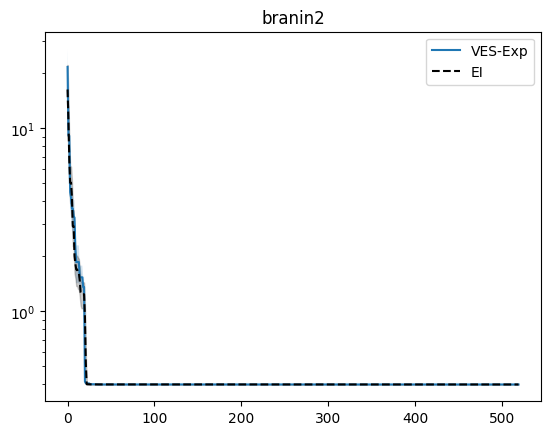

branin2: 0.96


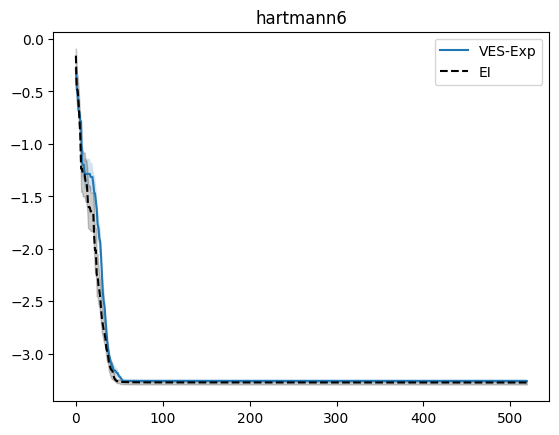

hartmann6: 1.0


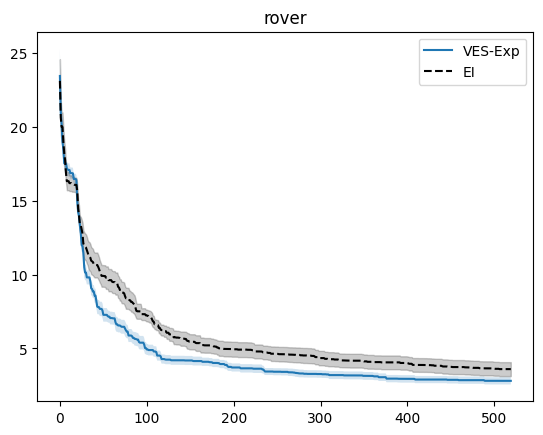

rover: 0.8


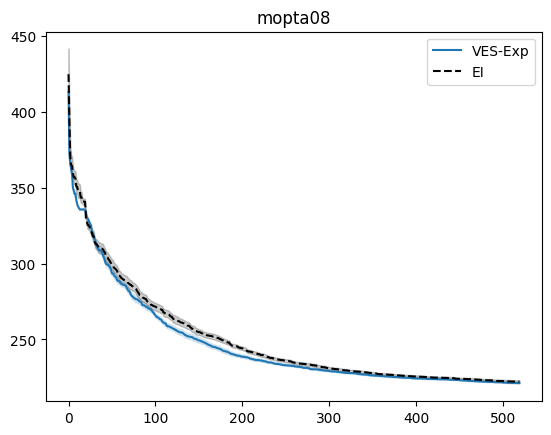

mopta08: 0.86


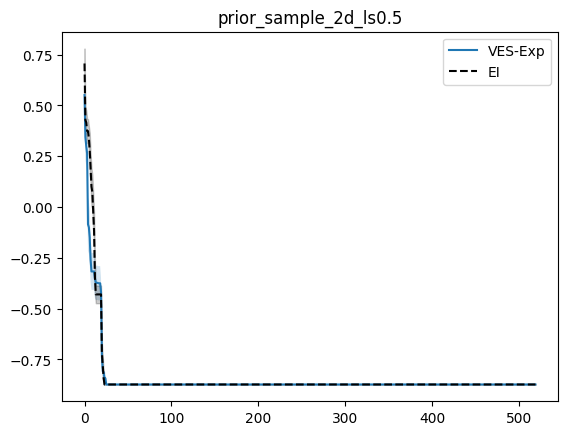

prior_sample_2d_ls0.5: 0.98


/opt/anaconda3/envs/botorchEnv2/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:605: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


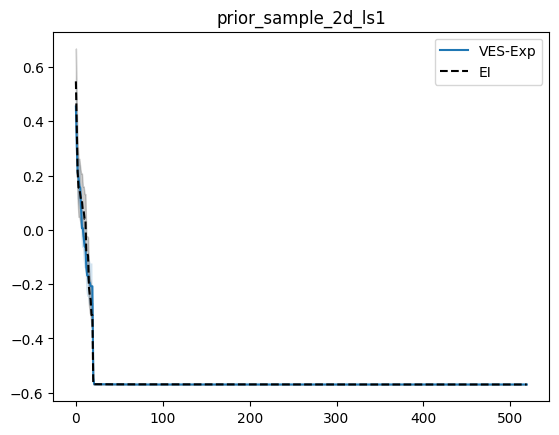

prior_sample_2d_ls1: 0.96


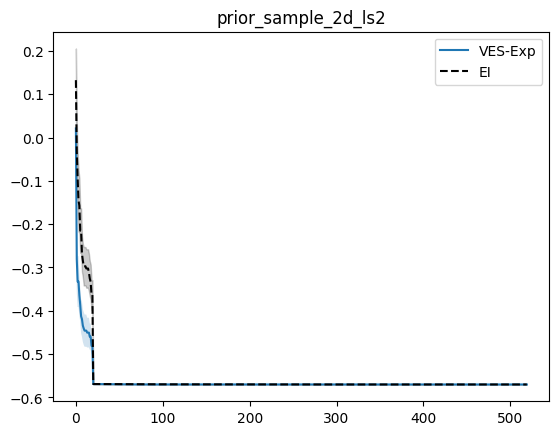

prior_sample_2d_ls2: 0.24


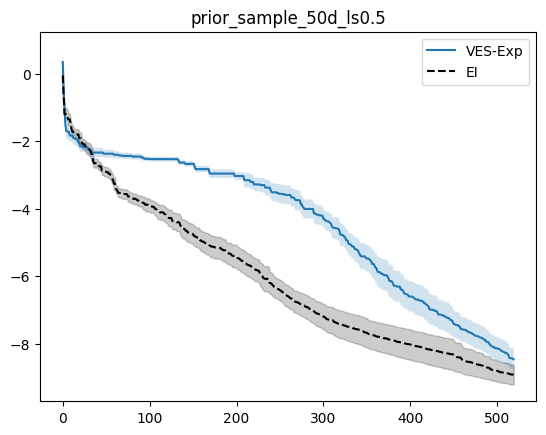

prior_sample_50d_ls0.5: 0.32


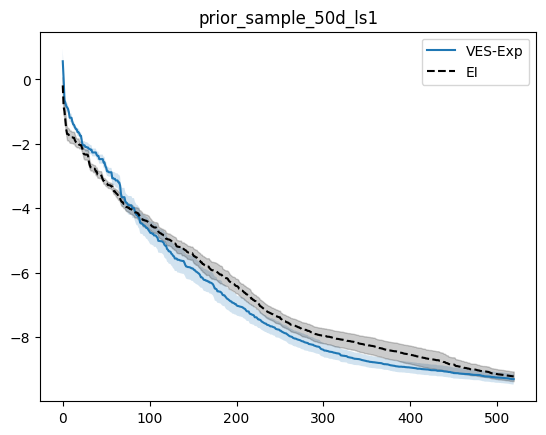

prior_sample_50d_ls1: 0.92


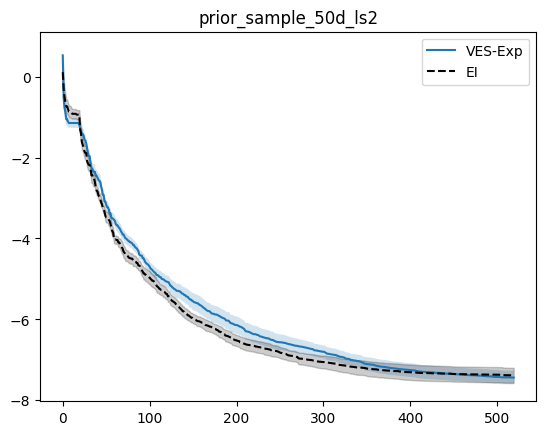

prior_sample_50d_ls2: 1.0


In [56]:
benchmarks = ['branin2','hartmann6', 'rover', 'mopta08', 'prior_sample_2d_ls0.5', 'prior_sample_2d_ls1', 'prior_sample_2d_ls2','prior_sample_50d_ls0.5', 'prior_sample_50d_ls1', 'prior_sample_50d_ls2']

run_dirs = glob.glob('../results/ei_vs_ves_exp_sep_17/*')

for benchmark in benchmarks:
    relevant_dirs = [d for d in run_dirs if json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]

    def def_dir_match(
            args: dict
    ):
        return args['clamp_min'] == 1e-10 \
            and args['sample_around_best'] == False \
            and args['acqf_raw_samples'] == 512 \
            and args['num_paths'] == 64


    ei_dirs = [d for d in relevant_dirs if f'{d}/train_x_ei.npy' in glob.glob(f'{d}/*')]
    # remove ei_dirs from relevant_dirs
    relevant_dirs = [d for d in relevant_dirs if d not in ei_dirs]
    
    default_dirs = [d for d in relevant_dirs if def_dir_match(json.load(open(f'{d}/args.json')))]

    fig, ax = plt.subplots()
    sample_around_bests = [False]
    ablation_dirs = [d for d in relevant_dirs if
                     json.load(open(f'{d}/args.json'))['sample_around_best'] in sample_around_bests] + default_dirs
    ablation_hashes = list(set([int(d.split('/')[-1].split('_')[1]) for d in ablation_dirs]))
    
    for h in ablation_hashes:
        dirs = [d for d in ablation_dirs if int(d.split('/')[-1].split('_')[1]) == h]
        ves_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ves.npy')) for d in dirs]
        if len(ves_y) == 0:
            continue
        min_len = min([len(y) for y in ves_y])
        ves_y = [y[:min_len] for y in ves_y]
        ves_y = -np.stack(ves_y).squeeze(-1)
        ves_y_mean = ves_y.mean(axis=0)
        ves_y_std = ves_y.std(axis=0)/ np.sqrt(len(ves_y))
        ax.plot(ves_y_mean, label=f'VES-Exp')
        ax.fill_between(np.arange(len(ves_y_mean)), ves_y_mean-ves_y_std, ves_y_mean+ves_y_std, alpha=0.2)
    ei_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ei.npy')) for d in ei_dirs]
    min_len = min([len(y) for y in ei_y])
    ei_y = [y[:min_len] for y in ei_y]
    ei_y = -np.stack(ei_y).squeeze(-1)
    ei_y_mean = ei_y.mean(axis=0)
    ei_y_std = ei_y.std(axis=0)/ np.sqrt(len(ei_y))
    ax.plot(ei_y_mean, label='EI', color='black', linestyle='--')
    ax.fill_between(np.arange(len(ei_y_mean)), ei_y_mean-ei_y_std, ei_y_mean+ei_y_std, alpha=0.2, color='black')
    ax.legend()
    ax.set_title(f'{benchmark}')
    if benchmark == 'branin2':
        ax.set_yscale('log')
    plt.show()

    # Perform an independent two-sample t-test
    idx = np.linspace(0, ves_y.shape[1]-1).astype(int)
    data1 = ves_y[:, idx]
    data2 = ei_y[:, idx]
    t_statistic, p_value = stats.ttest_ind(data1, data2)
    # votes = np.isnan(p_value) | (p_value >= 0.5)
    # votes = p_value >= 0.05
    votes = np.array([False] * len(p_value))
    votes[np.isnan(t_statistic)] = True
    votes[~np.isnan(t_statistic) & (p_value >= 0.05)] = True
    majority = np.sum(votes) / len(votes)
    print(f"{benchmark}: {majority}")
    